# Title

# Abstract

# Table of contents <a name="TOC"></a>
1. [Introduction](#intro)
2. [Data aquisition](#data-aquisition)
3. [Data exploration](#data-exploration)

# Introduction <a name="intro"></a>

[Go back to the top](#TOC)

# Data acquisition <a name="data-aquisition"></a>

[Go back to the top](#TOC)

The data we analyse are given by the NTDS course. They can be downloaded from [here](https://linqs-data.soe.ucsc.edu/public/lbc/TerrorAttack.tgz).

In [72]:
import pandas as pd
import numpy as np
from collections import Counter
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.cross_validation import KFold
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

In [2]:
PATH = "TerrorAttack/"
SEED = 0

In [3]:
# Load data
edges_org = pd.read_csv(PATH +'terrorist_attack_loc_org.edges', sep=' ', header=None)
edges = pd.read_csv(PATH +'terrorist_attack_loc.edges', sep=' ', header=None)
labels = pd.read_csv(PATH +'terrorist_attack.labels', sep=' ', header=None)
nodes = pd.read_csv(PATH +'terrorist_attack.nodes', sep='\t', header=None)

In [4]:
n_nodes = nodes.shape[0]

# Data exploration <a name="data-exploration"></a>

[Go back to the top](#TOC)

In [5]:
edges.head()

,0,1
0,http://counterterror.mindswap.org/2005/ict_eve...,http://counterterror.mindswap.org/2005/ict_eve...
1,http://counterterror.mindswap.org/2005/ict_eve...,http://counterterror.mindswap.org/2005/ict_eve...
2,http://counterterror.mindswap.org/2005/ict_eve...,http://counterterror.mindswap.org/2005/ict_eve...
3,http://counterterror.mindswap.org/2005/ict_eve...,http://counterterror.mindswap.org/2005/ict_eve...
4,http://counterterror.mindswap.org/2005/ict_eve...,http://counterterror.mindswap.org/2005/ict_eve...


In [6]:
edges[0][42]

'http://counterterror.mindswap.org/2005/ict_events.owl#Jihad_Group_19961117'

The edges are given by an internet link. However, there are information given inside the link: the name of the organization after `#` in the link and the date of the attack and the end of the link.  
  
We will extract these information and construct a new data frame.

In [7]:
# extract information of date and organization from the link
nodes_info = nodes[0].apply(lambda x : (x.split("#"))[1])
dates= nodes_info.apply(lambda x : x[-8:])
dates = pd.to_datetime(dates, format='%Y%m%d', errors='coerce')
organizations = nodes_info.apply(lambda x : x[:-9])

attacks_dict = {"organization": organizations, "date": dates}
attacks = pd.DataFrame(attacks_dict)

attacks.head()

,organization,date
0,United_Popular_Action_Movement,1993-05-13
1,Unknown,1996-11-12
2,Unknown,1998-04-28
3,Kurdistan_Worker_s_Party,1997-03-25
4,Unknown,1999-03-14


We observe that there are some unknown organizations. We want to know the number of the unknown values.

In [8]:
attacks.organization.value_counts().head()

Unknown                      519
Hamas                         99
Fatah_Tanzim                  52
Palestinian_Islamic_Jihad     50
                              48
Name: organization, dtype: int64

That is pretty much. We may predict the organization who is responsible of an attack for those unknown author. First, we check the proportion of attacks that are created by known organizations which create at least 10 attacks. In fact, if an organization only have few rows in the `nodes` dataset, it will be difficult to extract information from the limited rows.

In [9]:
nb_atk_threshold = 10

In [10]:
attacks.organization.replace('', 'Unknown', inplace=True)

In [11]:
attack_per_org = pd.DataFrame(attacks.organization.value_counts()[1:])
attack_per_org.columns=['count']
num_attacks = attack_per_org.sum()
prop_freq_org = (attack_per_org[attack_per_org['count']>=nb_atk_threshold].sum() / num_attacks )['count']

print("There are {:.2%} of known attacks are created by frequent organizations.".format(prop_freq_org))

There are 80.30% of known attacks are created by frequent organizations.


Which seems good for us to predict.

In [12]:
# concatenate features into the dataframe of attacks
attacks = pd.concat([attacks, nodes.iloc[:, 1:]], axis=1)
attacks.head()

,organization,date,1,2,3,4,5,6,7,8,...,98,99,100,101,102,103,104,105,106,107
0,United_Popular_Action_Movement,1993-05-13,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...
1,Unknown,1996-11-12,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...
2,Unknown,1998-04-28,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...
3,Kurdistan_Worker_s_Party,1997-03-25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...
4,Unknown,1999-03-14,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,http://counterterror.mindswap.org/2005/terrori...


In [13]:
ls = sorted(attacks.date[attacks.date.notna()])

We will now also have a look on the number of attacks w.r.t time. 

In [14]:
attack_year = [t.year for t in ls]

print("Our data contains attacks start from year {} till {}"
      .format(min(set(attack_year)), max(set(attack_year))))

Our data contains attacks start from year 1969 till 2002


/home/painguin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


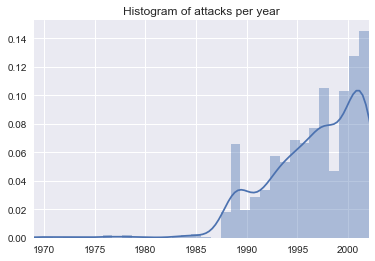

In [15]:
sns.distplot(attack_year, bins=34)
plt.title('Histogram of attacks per year')
plt.xlim([1969,2002]);

/home/painguin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


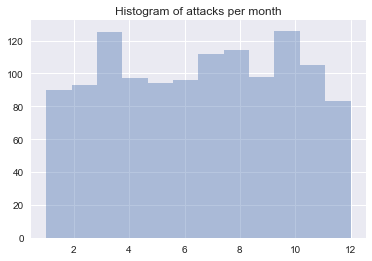

In [16]:
attack_month = [t.month for t in ls]

sns.distplot(attack_month, bins=12, kde=False)
plt.title('Histogram of attacks per month');

In [17]:
features_adjacency = np.exp(-squareform(pdist(nodes.drop([0, 107], axis=1))))

In [18]:
# put the diagonal values to 0
features_adjacency[(range(n_nodes), range(n_nodes))] = 0

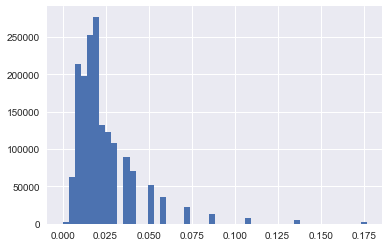

In [19]:
plt.hist(features_adjacency[features_adjacency < 0.2].ravel(), bins=50);

In [20]:
# sparsify the matrix (and unconnect the graph) by removing small weights
features_adjacency[features_adjacency < 0.05] = 0 

In [21]:
n_nodes = len(nodes)

In [22]:
coloc_adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
for idx, row in edges.iterrows():
    n1, n2 = row # retrieve the nodes from the edge
    idx_n1 = nodes[nodes[0] == n1].index[0]
    idx_n2 = nodes[nodes[0] == n2].index[0]
    
    # increment by one in (n1, n2) and (n2, n1) entries
    coloc_adjacency[idx_n1, idx_n2] += 1
    coloc_adjacency[idx_n2, idx_n1] += 1

coloc_org_adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
for idx, row in edges_org.iterrows():
    n1, n2 = row # retrieve the nodes from the edge
    idx_n1 = nodes[nodes[0] == n1].index[0]
    idx_n2 = nodes[nodes[0] == n2].index[0]
    
    # increment by one in (n1, n2) and (n2, n1) entries
    coloc_org_adjacency[idx_n1, idx_n2] += 1
    coloc_org_adjacency[idx_n2, idx_n1] += 1

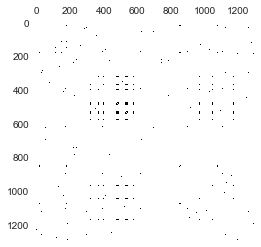

In [23]:
plt.spy(coloc_adjacency)

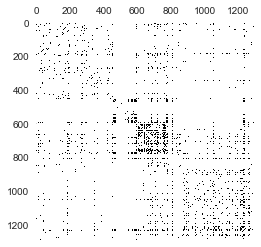

In [24]:
plt.spy(features_adjacency)

In [25]:
# get only the type of attack from last column
nodes.iloc[:, -1] = nodes.iloc[:, -1].apply(lambda x: x.split('#')[1])

#### Check similarity within organization

To see if it is relevant to try to predict the organizations based on the features, we check if the feature distance between attacks of the same organization are smaller than across organizations.

In [26]:
with_dummies = pd.get_dummies(nodes.iloc[:, 1:])

In [27]:
distances = pdist(with_dummies)
kernel_width = distances.mean()
weights = np.exp(-distances**2 / kernel_width**2)

In [28]:
sim_matrix = squareform(weights)

In [29]:
diffs = []

for i in range(n_nodes):
    org = attacks['organization'][i]
    sim = sim_matrix[i]
    if org != 'Unknown' and attack_per_org.loc[org]['count'] >= 10:
        org_indices = attacks[attacks.organization == org].index
        diffs += [sim[org_indices].mean() - sim.mean()]

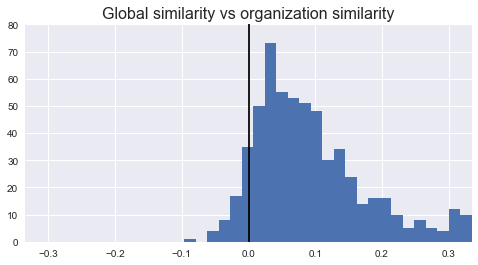

In [30]:
plt.figure(figsize=(8,4))
plt.hist(diffs, bins=25)
plt.xlim(-max(diffs), max(diffs))
plt.ylim((0, 80))
plt.vlines(0, 0, 80)
plt.title('Global similarity vs organization similarity', size=16)
plt.savefig('similarity_difference.png');

In [31]:
# only select organizations 
famous_orgs = attack_per_org[attack_per_org['count'] >= 10]

#### Cross-validation

In [42]:
# create a mapping between the organizations and labels
idx_to_org = pd.DataFrame(famous_orgs.index, columns=['organization'])
org_to_idx = idx_to_org.reset_index().set_index('organization')

idx_to_org.head()

,organization
0,Hamas
1,Fatah_Tanzim
2,Palestinian_Islamic_Jihad
3,Basque_Homeland_and_Freedom
4,Martyrs_of_al-Aqsa


In [34]:
X = with_dummies[attacks.organization.apply(lambda x: x in org_to_idx.index)]
y = attacks[attacks.organization.apply(lambda x: x in org_to_idx.index)].organization.apply(lambda x: org_to_idx.loc[x])

In [36]:
correct = Counter()
total = Counter()

for train_idx, test_idx in KFold(X.shape[0], 4, shuffle=True, random_state=SEED):
    # split the data
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]
    
    # fit the model
    model = OneVsRestClassifier(LinearSVC(random_state=SEED))
    model.fit(X_train, y_train)
    
    # predict
    y_pred = model.predict(X_test)
    
    y_pred_orgs = idx_to_org.loc[y_pred]
    y_test_orgs = idx_to_org.loc[y_test['index']]
    
    for i in range(len(y_pred)):
        y_p = y_pred_orgs.iloc[i].organization
        y_t = y_test_orgs.iloc[i].organization

        total[y_t] += 1
        if y_p == y_t:
            correct[y_t] += 1

In [37]:
prediction_comparision = pd.DataFrame([correct, total]).T.fillna(0)
prediction_comparision.columns = ['correct', 'total']

In [43]:
correctly_predicted = prediction_comparision.correct.sum()
print('With %d correct predictions from a total of %d samples, we obtain a success rate of %.3f%%.'
      % (correctly_predicted, y.shape[0], 100 * correctly_predicted / y.shape[0]))

With 532 correct predictions from a total of 583 samples, we obtain a success rate of 91.252%.


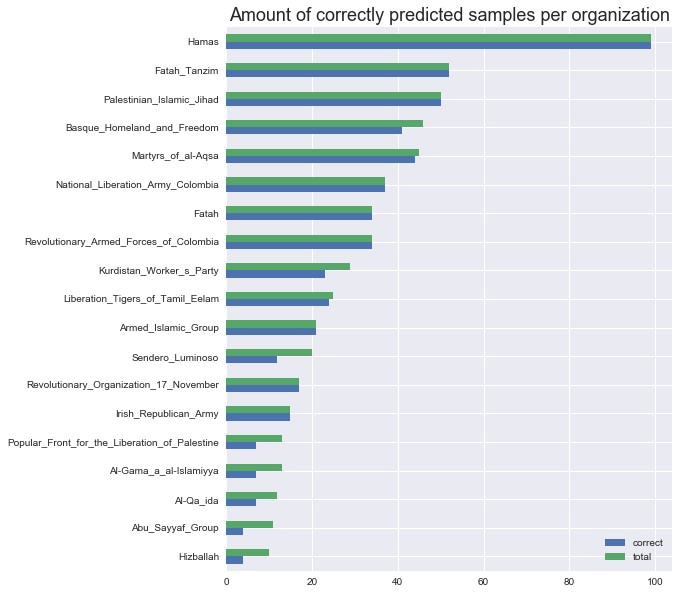

In [39]:
prediction_comparision.sort_values('total').plot.barh(figsize=(8, 10))
plt.title('Amount of correctly predicted samples per organization', size=18);

For most of the top 19 organizations, the predictions we obtain are very accurate! We observe however that our model has more trouble predicting organizations with few attacks because of the consequently small amount of training data for the organization.

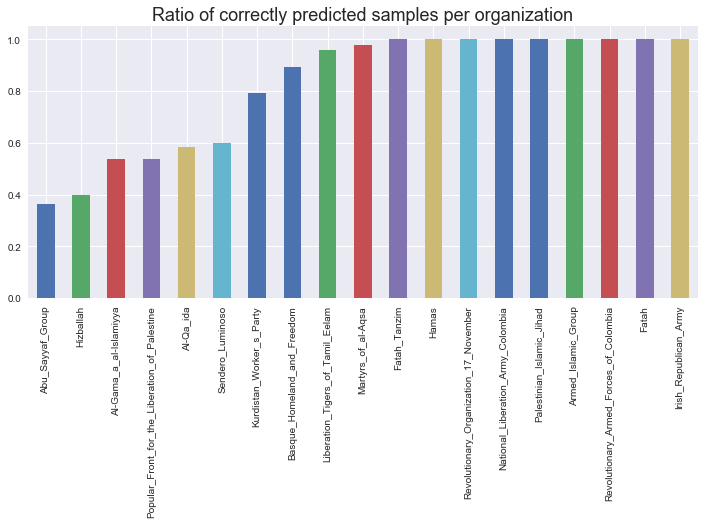

In [44]:
(prediction_comparision.correct / prediction_comparision.total).sort_values().plot.bar(figsize=(12,5))
plt.title('Ratio of correctly predicted samples per organization', size= 18);

#### Predict the unknown organizations

In [76]:
X_train = with_dummies[attacks.organization.apply(lambda x: x in org_to_idx.index)]
y_train = attacks[attacks.organization.apply(lambda x: x in org_to_idx.index)].organization.apply(lambda x: org_to_idx.loc[x])
X_unknown = with_dummies[attacks.organization.apply(lambda x: x in 'Unknown')]

model = OneVsRestClassifier(LinearSVC(random_state=SEED))
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_unknown)
y_pred_orgs = idx_to_org.loc[y_pred]

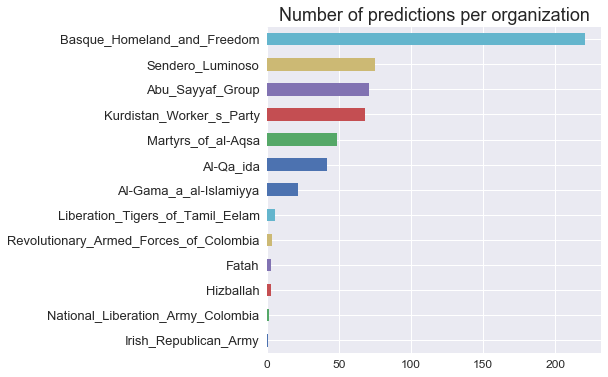

In [108]:
y_pred_orgs.organization.value_counts().iloc[::-1].plot.barh(figsize=(6, 6))
plt.title('Number of predictions per organization', size=18)
plt.yticks(size=13)
plt.xticks(size=12)
plt.savefig('unknown_predictions.png');